# Draw scenario

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.basemap import Basemap


# Assuming the scenario CSV and JSON files have been uploaded and are accessible at specified paths
scenario_csv_path = '/Users/dexterlam/Desktop/Aarhus.Universitet/Speciale /Data_fra_terma/iamd/scenario-5threat.csv'



# Load scenario data
scenario_df = pd.read_csv(scenario_csv_path)

# Load flight paths data
flight_paths = scenario_df

entities_json_path = '/Users/dexterlam/Desktop/Aarhus.Universitet/Speciale /Data_fra_terma/iamd/entities.json'
threat_types_json_path = '/Users/dexterlam/Desktop/Aarhus.Universitet/Speciale /Data_fra_terma/iamd/threat-types.json'

# Load entities data
with open(entities_json_path, 'r') as file:
    entities = json.load(file)

# Assuming 'threat_details.json' is the file where the JSON content is stored
with open(threat_types_json_path, 'r') as file:
    threat_details = json.load(file)





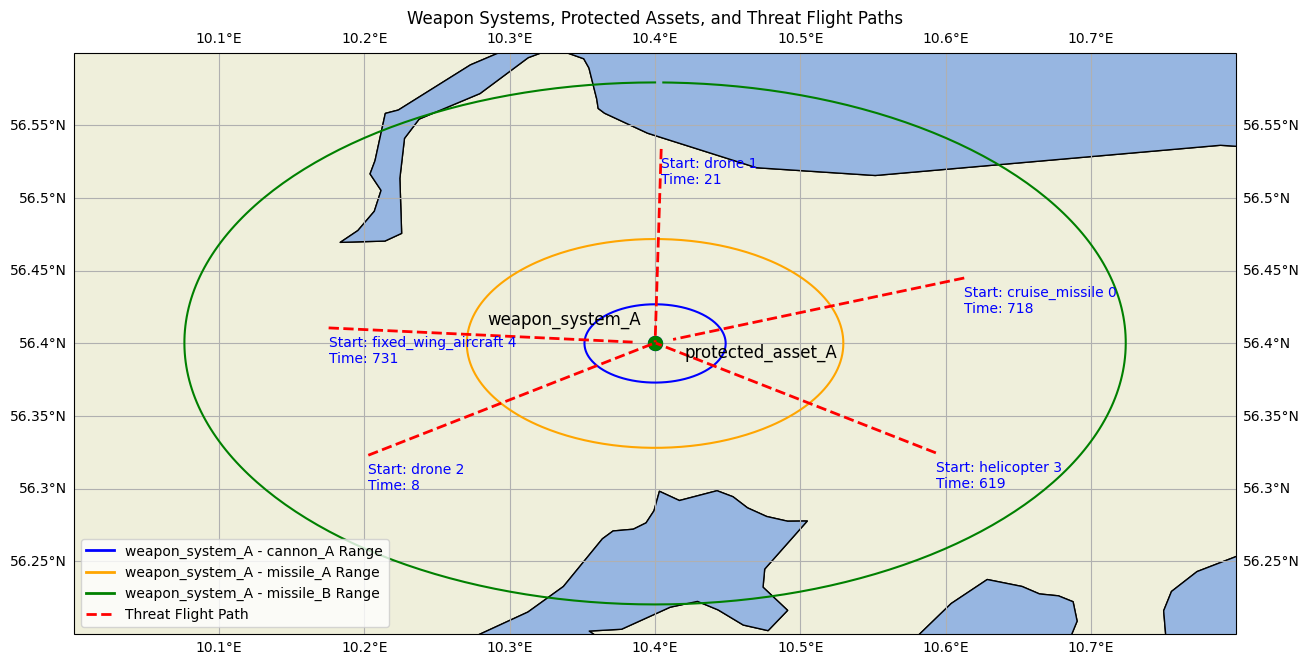

In [7]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import json
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
from cartopy import geodesic


# Initialize lists for weapon systems and protected assets
weapon_systems = {}
protected_assets = []

# Iterate through entities and classify them into weapon systems or protected assets
for name, details in entities.items():
    if 'interceptors' in details:
        weapon_systems[name] = {
            "location": (details["location_lat"], details["location_lon"]),
            "location_range_m": details["location_range_m"],
            "kill_assessment_time_seconds": details["kill_assesment_time_seconds"],
            "interceptors": {}
        }
        for interceptor_name, interceptor_details in details["interceptors"].items():
            weapon_systems[name]["interceptors"][interceptor_name] = {
                "type": interceptor_details["type"],
                "probability_of_kill_max": interceptor_details["probability_of_kill_max"],
                "probability_of_kill_min": interceptor_details["probability_of_kill_min"],
                "range_max_meters": interceptor_details["range_max_meters"],
                "average_velocity_ms": interceptor_details["average_velocity_ms"],
                "shots_per_launch": interceptor_details.get("shots_per_launch", 1),
                "inventory": interceptor_details["inventory"],
                "cost_per_shot": interceptor_details["cost_per_shot"]
            }
    else:
        # This is a protected asset
        protected_asset = {
            'name': name,
            'location_lat': details['location_lat'],
            'location_lon': details['location_lon'],
            'location_range_m': details['location_range_m']
        }
        protected_assets.append(protected_asset)

# Plotting the map
plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([10.0, 10.8, 56.2, 56.6], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.RIVERS)
ax.gridlines(draw_labels=True)

# Plot weapon systems and their effective ranges
colors = ['blue', 'orange', 'green', 'red', 'purple']  # Add more colors if needed
legend_elements = []
color_idx = 0

for name, details in weapon_systems.items():
    lat, lon = details['location']
    ax.plot(lon, lat, 'bo', markersize=10, transform=ccrs.PlateCarree())
    plt.text(lon - 0.01, lat+ 0.01, name, fontsize=12, ha='right', va='bottom', transform=ccrs.PlateCarree())

    for interceptor_name, interceptor_details in details['interceptors'].items():
        range_km = interceptor_details['range_max_meters'] / 1000  # Convert meters to kilometers
        geod_circle = geodesic.Geodesic().circle(lon=lon, lat=lat, radius=range_km * 1000, n_samples=360)
        ax.plot(geod_circle[:, 0], geod_circle[:, 1], color=colors[color_idx % len(colors)], transform=ccrs.Geodetic())
        legend_elements.append(Line2D([0], [0], color=colors[color_idx % len(colors)], lw=2, label=f'{name} - {interceptor_name} Range'))
        color_idx += 1

# Plot protected assets
for asset in protected_assets:
    lat, lon = asset['location_lat'], asset['location_lon']
    ax.plot(lon, lat, 'go', markersize=10, transform=ccrs.PlateCarree())
    plt.text(lon + 0.02, lat, asset['name'], fontsize=12, ha='left', va='top', transform=ccrs.PlateCarree())

# Plot flight paths and add labels
uids = flight_paths['uid'].unique()
for uid in uids:
    path = flight_paths[flight_paths['uid'] == uid]
    latitudes = path['latitude'].tolist()
    longitudes = path['longitude'].tolist()
    threat_type = path['type'].iloc[0]  # Assuming type is consistent for the same UID
    start_time = path['time'].iloc[0]  # Get the starting time for the threat

    # Plot the flight path
    ax.plot(longitudes, latitudes, 'r--', linewidth=2, transform=ccrs.PlateCarree())

    # Label the start point with threat type and start time
    plt.text(longitudes[0], latitudes[0]- 0.005, f"Start: {threat_type} {uid}\nTime: {start_time}", fontsize=10, ha='left', va='top', color='blue', transform=ccrs.PlateCarree())

# Add legend
legend_elements.append(Line2D([0], [0], color='red', lw=2, linestyle='--', label='Threat Flight Path'))
ax.legend(handles=legend_elements, loc='lower left')

plt.title("Weapon Systems, Protected Assets, and Threat Flight Paths")
plt.show()


# SOLUTION - NSGA-III

In [8]:
import numpy as np
from pymoo.core.problem import Problem, ElementwiseProblem
import autograd.numpy as anp

class MOMWTAProblem(ElementwiseProblem):
    def __init__(self, rho, pi, v, beta, m, S, K, W, T,Tk, n, N, f):
        self.rho = np.array(rho)  # Kill probability matrix for weapons against targets across stages
        self.pi = np.array(pi)  # Probability of target destroying asset
        self.v = np.array(v)  # Value of each asset
        self.beta = np.array(beta)  # Economic cost of ammunition
        self.m = np.array(m)  # Weapon cost for each target at each stage
        
        self.S = S  # Number of stages


        self.W = W  # Number of weapons
        self.T = T  # Number of targets
        self.Tk = Tk # index set of targets aimed at asset k
        self.K = K # Number of assets

        self.n = np.array(n)  # Capacity of weapons to fire at multiple targets
        self.N = np.array(N)  # Ammo limits for each weapon type
        self.f = np.array(f)  # Feasibility of weapon against target at stage
        
        
        # Set up decision variable bounds
        xl = np.zeros(self.S * self.W * self.T)  # Lower bounds
        xu = np.ones(self.S * self.W * self.T)  # Upper bounds, assuming binary decision variables

        # Initialize the pymoo Problem class
        n_var = S * W * T
        super().__init__(n_var=n_var, n_obj=2, n_constr=self.S*self.W + self.S*self.T + self.W
                         + self.S*self.W*self.T, xl=xl,
                         xu=xu, elementwise_evaluation=True, vtype=bool)


    def _evaluate(self, X, out, *args, **kwargs):
        # print("Received solution size:", X.shape)
        X = X.reshape((self.S, self.W, self.T))
        

        # Calculate objectives
        f1 = self.calculate_value_of_assets(X)
        f2 = self.calculate_ammunition_consumption(X)
        
        # print(f1,f2)

        # Assign objective values
        out["F"] = anp.column_stack([-f1, f2])  # Note the negative sign for maximization
            
        # Initialize lists for each constraint set
        c1, c2, c3, c4 = [], [], [], []
        
        # Constraint 1: Weapon capacity per stage
        for t in range(self.S):
            for i in range(self.W):
                c1.append(np.sum(X[t, i, :]) - self.n[i])
        

        # Constraint 2: Target capacity per stage
        for t in range(self.S):
            for j in range(self.T):
                c2.append(np.sum(X[t, :, j]) - self.m[j])
        
        # Constraint 3: Ammunition limit for each weapon
        for i in range(self.W):
            c3.append(np.sum(self.beta[i]*X[:, i, :]) - self.N[i])
        

        # Constraint 4: Engagement feasibility
        for t in range(self.S):
            for i in range(self.W):
                for j in range(self.T):
                    c4.append(X[t, i, j] - self.f[t, i, j] if X[t, i, j] > self.f[t, i, j] else 0)

        


        # # Stack all violations together. Since g1 and g2 are already 1D arrays, we use np.hstack
        g = np.hstack((np.array(c1), np.array(c2), np.array(c3), np.array(c4)))
        
        # Update constraint violations in the output
        out["G"] = g



    def calculate_value_of_assets(self, X):
        t = 0 #this is the stage, should be updated to be dynamic
        J_t = 0
        # Iterate over each asset at stage t
        for k in range(self.K):
            product_inner = self.v[k]
            # Iterate over each target j that could affect asset k at stage t
            for j in self.Tk[k]:
                product_j = self.pi[j, k]

                # Iterate over time stages from current stage t to final stage S
                for h in range(t, self.S):
                    product_i_h = 1
                    # Iterate over each weapon available at stage t
                    for i in range(self.W):
                        # Check if weapon i is assigned to target j at stage h
                        if h < X.shape[0] and i < X.shape[1] and j < X.shape[2]:
                            product_i_h *= (1 - self.rho[h,i, j])**X[h,i, j]

                    product_j *= product_i_h
                                
                product_inner *= 1 - product_j

            J_t += product_inner
        return J_t




    def calculate_ammunition_consumption(self, X):
        # Objective function for ammunition consumption
        # C_ammo = np.sum(X)
        C_ammo = np.sum([self.beta[i] * X[s, i, j]  for s in range(self.S)
                                                    for j in range(self.T)
                                                    for i in range(self.W)] )
        return C_ammo


# Optimizing the scenario example

# Get data - split stages

In [24]:
import pandas as pd
import json

# Assuming the scenario CSV and JSON files have been uploaded and are accessible at specified paths
# scenario_csv_path = '/Users/dexterlam/Desktop/Aarhus.Universitet/Speciale /Kode/Multistage/Testcases/scenarios/scenario-3.csv'
# scenario_csv_path = '/Users/dexterlam/Desktop/Aarhus.Universitet/Speciale /Data_fra_terma/iamd/scenario-202405212001.csv'

# Load scenario data
scenario_df = pd.read_csv(scenario_csv_path)


# Assuming time window T is defined in seconds and we want to split the scenario into windows of T seconds
# For this example, let's assume each time window T is 60 seconds (1 minute)
T = 300

# Calculate the max time to define the last window
max_time = scenario_df['time'].max()

# Generate time windows based on max_time and T
time_windows = range(0, max_time + T, T)

# Function to classify threats by time window
def classify_threats_by_time_window(scenario_df, time_windows):
    # Initialize a dictionary to hold threats classified by time window
    threats_by_time_window = {tw: [] for tw in time_windows}
    
    # Iterate through each time window and classify threats
    for i in range(len(time_windows) - 1):
        start, end = time_windows[i], time_windows[i+1]
        # Filter threats active within the current time window
        active_threats = scenario_df[(scenario_df['time'] >= start) & (scenario_df['time'] < end)]
        # Add the active threats to the corresponding time window
        threats_by_time_window[start] = active_threats
    
    return threats_by_time_window

# Classify threats into time windows
threats_by_time_window = classify_threats_by_time_window(scenario_df, time_windows)
number_of_time_windows = 0
# Show active threats in the first few time windows as an example
for tw, threats in list(threats_by_time_window.items())[:-1]:  # Exclude the last item from iteration
    if not threats.empty:  # Check if the threats DataFrame is not empty
        number_of_time_windows += 1
        print(f"Time Window {tw} to {tw + T} seconds: {len(threats)} active threats")
        print(threats[['uid', 'type', 'time', 'latitude', 'longitude']], '\n')

print(number_of_time_windows)

Time Window 0 to 300 seconds: 115 active threats
     uid   type  time   latitude  longitude
0      2  drone     8  56.323065  10.202662
1      2  drone    13  56.323557  10.203917
2      2  drone    18  56.324049  10.205171
3      1  drone    21  56.533836  10.404228
4      2  drone    23  56.324541  10.206426
..   ...    ...   ...        ...        ...
110    2  drone   288  56.350620  10.272932
111    1  drone   291  56.487773  10.402771
112    2  drone   293  56.351112  10.274187
113    1  drone   296  56.486920  10.402744
114    2  drone   298  56.351604  10.275443

[115 rows x 5 columns] 

Time Window 300 to 600 seconds: 120 active threats
     uid   type  time   latitude  longitude
115    1  drone   301  56.486067  10.402717
116    2  drone   303  56.352096  10.276698
117    1  drone   306  56.485214  10.402691
118    2  drone   308  56.352588  10.277953
119    1  drone   311  56.484361  10.402664
..   ...    ...   ...        ...        ...
230    2  drone   588  56.380143  10.3

# Get entities and threat data

In [25]:
# entities_json_path = '/Users/dexterlam/Desktop/Aarhus.Universitet/Speciale /Data_fra_terma/iamd/entities_2WS.json'
entities_json_path = '/Users/dexterlam/Desktop/Aarhus.Universitet/Speciale /Data_fra_terma/iamd/entities.json'
threat_types_json_path = '/Users/dexterlam/Desktop/Aarhus.Universitet/Speciale /Data_fra_terma/iamd/threat-types.json'

# Entities

In [26]:
import json

# Load entities data
with open(entities_json_path, 'r') as file:
    entities = json.load(file)

# Initialize lists for weapon systems and protected assets
weapon_systems = {}
protected_assets = []

# Iterate through entities and classify them into weapon systems or protected assets
for name, details in entities.items():
    if 'interceptors' in details:
        weapon_systems[name] = {
            "location": (details["location_lat"], details["location_lon"]),
            "location_range_m": details["location_range_m"],
            "kill_assessment_time_seconds": details["kill_assesment_time_seconds"],
            "interceptors": {}
        }
        for interceptor_name, interceptor_details in details["interceptors"].items():
            weapon_systems[name]["interceptors"][interceptor_name] = {
                "type": interceptor_details["type"],
                "probability_of_kill_max": interceptor_details["probability_of_kill_max"],
                "probability_of_kill_min": interceptor_details["probability_of_kill_min"],
                "range_max_meters": interceptor_details["range_max_meters"],
                "average_velocity_ms": interceptor_details["average_velocity_ms"],
                "shots_per_launch": interceptor_details.get("shots_per_launch", 1),
                "inventory": interceptor_details["inventory"],
                "cost_per_shot": interceptor_details["cost_per_shot"]
            }
            # Additional parameters like "shots_per_launch", "shots_per_second", and "shift_target_time_s" can be added similarly if needed

    else:
        # This is a protected asset
        protected_asset = {
            'name': name,
            'location_lat': details['location_lat'],
            'location_lon': details['location_lon'],
            'location_range_m': details['location_range_m']
        }
        protected_assets.append(protected_asset)

# Print the lists for review
# Example usage
print("Weapon Systems:")
for name, details in weapon_systems.items():
    print(f"Name: {name}, Details: {details}")

print("\nProtected Assets:")
for pa in protected_assets:
    print(f"Name: {pa['name']}, Location: ({pa['location_lat']}, {pa['location_lon']}), Range: {pa['location_range_m']}m")


Weapon Systems:
Name: weapon_system_A, Details: {'location': (56.4, 10.4), 'location_range_m': 100, 'kill_assessment_time_seconds': 5, 'interceptors': {'cannon_A': {'type': 'cannon', 'probability_of_kill_max': 0.95, 'probability_of_kill_min': 0.5, 'range_max_meters': 3000, 'average_velocity_ms': 1150, 'shots_per_launch': 6, 'inventory': 250, 'cost_per_shot': 0}, 'missile_A': {'type': 'missile', 'probability_of_kill_max': 0.9, 'probability_of_kill_min': 0.7, 'range_max_meters': 8000, 'average_velocity_ms': 1029, 'shots_per_launch': 1, 'inventory': 4, 'cost_per_shot': 0}, 'missile_B': {'type': 'missile', 'probability_of_kill_max': 0.9, 'probability_of_kill_min': 0.7, 'range_max_meters': 20000, 'average_velocity_ms': 1029, 'shots_per_launch': 1, 'inventory': 1, 'cost_per_shot': 0}}}

Protected Assets:
Name: protected_asset_A, Location: (56.4, 10.4), Range: 200m


In [27]:
# Dictionary to hold the number of interceptors for each weapon system
num_interceptors_dict = {}

# Populate num_interceptors_dict with the number of interceptors for each weapon system
for system_name, system_details in weapon_systems.items():
    num_interceptors = len(system_details['interceptors'])
    num_interceptors_dict[system_name] = num_interceptors

# Now you can access the number of interceptors for each weapon system directly from num_interceptors_dict
# Example: Print the number of interceptors for each weapon system
for system_name, num_interceptors in num_interceptors_dict.items():
    print(f"Weapon System: {system_name}, Number of Interceptors: {num_interceptors}")


print("Weapon Systems:" , weapon_systems)
print(num_interceptors_dict)


Weapon System: weapon_system_A, Number of Interceptors: 3
Weapon Systems: {'weapon_system_A': {'location': (56.4, 10.4), 'location_range_m': 100, 'kill_assessment_time_seconds': 5, 'interceptors': {'cannon_A': {'type': 'cannon', 'probability_of_kill_max': 0.95, 'probability_of_kill_min': 0.5, 'range_max_meters': 3000, 'average_velocity_ms': 1150, 'shots_per_launch': 6, 'inventory': 250, 'cost_per_shot': 0}, 'missile_A': {'type': 'missile', 'probability_of_kill_max': 0.9, 'probability_of_kill_min': 0.7, 'range_max_meters': 8000, 'average_velocity_ms': 1029, 'shots_per_launch': 1, 'inventory': 4, 'cost_per_shot': 0}, 'missile_B': {'type': 'missile', 'probability_of_kill_max': 0.9, 'probability_of_kill_min': 0.7, 'range_max_meters': 20000, 'average_velocity_ms': 1029, 'shots_per_launch': 1, 'inventory': 1, 'cost_per_shot': 0}}}}
{'weapon_system_A': 3}


# Threats

In [28]:
# Assuming 'threat_details.json' is the file where the JSON content is stored
with open(threat_types_json_path, 'r') as file:
    threat_details = json.load(file)

# Now, you can access the threat details
for threat, details in threat_details.items():
    print(f"Threat: {threat}, Details: {details}")

Threat: cruise_missile, Details: {'speed_ms': 189, 'threat_level': 3, 'kill_range_m': 0}
Threat: drone, Details: {'speed_ms': 19, 'threat_level': 4, 'kill_range_m': 100}
Threat: helicopter, Details: {'speed_ms': 81, 'threat_level': 2, 'kill_range_m': 1500}
Threat: fixed_wing_aircraft, Details: {'speed_ms': 216, 'threat_level': 1, 'kill_range_m': 2000}


In [29]:
# Load the scenario data
scenario_df = pd.read_csv(scenario_csv_path)

# Count distinct targets
distinct_targets_count = scenario_df['uid'].nunique()

print(scenario_df['uid'].unique())

print(f"Number of distinct targets: {distinct_targets_count}")

# print(sum(num_interceptors_dict.values()))

[2 1 3 0 4]
Number of distinct targets: 5


# Define the optimization problem

# Helper function

In [30]:
def haversine(coord1, coord2):
    """
    Calculate the great circle distance in meters between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lat1, lon1 = np.radians(coord1)
    lat2, lon2 = np.radians(coord2)
    
    # haversine formula 
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371000  # Radius of earth in meters
    return c * r

# Find the targets aimed at each asset

In [31]:
# Function to calculate the closest asset to a given coordinate
def closest_asset(lat, lon, assets):
    min_distance = float('inf')
    closest_asset_name = None
    for asset in assets:
        asset_lat = asset['location_lat']
        asset_lon = asset['location_lon']
        distance = haversine((lat, lon), (asset_lat, asset_lon))
        if distance < min_distance:
            min_distance = distance
            closest_asset_name = asset['name']
    return closest_asset_name

# Get the last coordinate of each threat
last_coordinates = scenario_df.groupby('uid').last().reset_index()

# Determine the closest asset for each last coordinate
last_coordinates['closest_asset'] = last_coordinates.apply(
    lambda row: closest_asset(row['latitude'], row['longitude'], protected_assets), axis=1
)

# Create the final list of lists containing the UIDs of the targets aimed at each asset
final_targets_per_asset = {asset['name']: [] for asset in protected_assets}

for _, row in last_coordinates.iterrows():
    final_targets_per_asset[row['closest_asset']].append(row['uid'])

# Convert the dictionary to a list of lists
final_targets_list_of_lists = list(final_targets_per_asset.values())

final_targets_list_of_lists

[[0, 1, 2, 3, 4]]

# Define the rest

In [32]:

# Mock data for the problem
S = number_of_time_windows #Number of stages

K = len(protected_assets)  # Number of assets
W = sum(num_interceptors_dict.values())  # Number of weapons
T = distinct_targets_count  # Number of targets
Tk = final_targets_list_of_lists





# index set of targets aimed at asset k

print("Stages", S)
print("Number of weapons", W)
print("Number of assets", K)
print("Number of targets", T)

# Remember the probability depends on the ranges, so either i can just at first assume
# that the probability is the same for each weapon through all stages
# or i can calculate the probability for each weapon for each stage, based on the distance to the
# target and the range of the weapon

# Assuming the order of weapons as cannon_A, missile_A, missile_B for indexing

max_pk_values = {interceptor: details["probability_of_kill_max"]
                 for _, system in weapon_systems.items()
                 for interceptor, details in system["interceptors"].items()}


min_pk_values = {interceptor: details["probability_of_kill_min"]
                 for _, system in weapon_systems.items()
                 for interceptor, details in system["interceptors"].items()}


print(max_pk_values)
# print(min_pk_values)


# Initialize the rho matrix with zeros
rho = np.zeros((S, W, T))

# pi = np.reshape(np.ones(T * K), (T, K)) # Probability of target destroying asset
pi = np.reshape(np.zeros(T * K), (T, K))


v = np.array([100]*K)  # Value of the assets



beta = list({interceptor: details["shots_per_launch"]
                 for _, system in weapon_systems.items()
                 for interceptor, details in system["interceptors"].items()}.values())

print(beta)


m = np.array([W]*T)  # maximum number of different weapons that can be used to destroy each target at each stage
n = np.array([1]*W)  # Weapon engagement capacity - how many targets can be engaged by each weapon at each stage


max_inventory = {interceptor: details["inventory"]
                 for _, system in weapon_systems.items()
                 for interceptor, details in system["interceptors"].items()}

N = np.array(list(max_inventory.values()))  # Ammo limits

print(m)
print(N)

Stages 3
Number of weapons 3
Number of assets 1
Number of targets 5
{'cannon_A': 0.95, 'missile_A': 0.9, 'missile_B': 0.9}
[6, 1, 1]
[3 3 3 3 3]
[250   4   1]


# Update the pi matrix based on threat level

In [33]:
# Extract the unique target UIDs and their types
unique_targets = scenario_df[['uid', 'type']].drop_duplicates().sort_values(by='uid')

# Number of targets (T) and assets (K)
T = len(unique_targets)

print(unique_targets)

# threat_level_to_percentage = {
#     4: 0.05,         # 0%
#     3: 1/3,    # 33.33333%
#     2: 2/3,    # 66.66667%
#     1: 1        # 100%
# }

threat_level_to_percentage = {
    4: 0.05,         # 0%
    3: 0.20,    # 33.33333%
    2: 0.50,    # 66.66667%
    1: 1        # 100%
}


# # Populate the pi matrix based on the threat type of each target
for uid, threat_type in unique_targets.itertuples(index=False):
    threat_level = threat_details[threat_type]["threat_level"]
    percentage = threat_level_to_percentage[threat_level]
    pi[uid, :] = percentage

print("Probability Matrix (pi) with Threat Levels:")
print(pi)



     uid                 type
302    0       cruise_missile
3      1                drone
0      2                drone
243    3           helicopter
313    4  fixed_wing_aircraft
Probability Matrix (pi) with Threat Levels:
[[0.2 ]
 [0.05]
 [0.05]
 [0.5 ]
 [1.  ]]


# Classify the threats with coordinates

In [34]:

def classify_and_store_threats_by_time_window(scenario_df, time_windows):
    # Initialize a dictionary to hold threats classified by time window
    threats_by_stage = {}

    for i in range(len(time_windows) - 1):
        start, end = time_windows[i], time_windows[i+1]
        active_threats = scenario_df[(scenario_df['time'] >= start) & (scenario_df['time'] < end)]

        if not active_threats.empty:
            stage_targets = {}
            for uid, group in active_threats.groupby('uid'):
                # Store each target's coordinates as they appear
                coords = group[['latitude', 'longitude']].values.tolist()
                stage_targets[uid] = coords

            threats_by_stage[start] = stage_targets

    return threats_by_stage

# Use the enhanced function
threats_by_stage = classify_and_store_threats_by_time_window(scenario_df, time_windows)

# For example, printing the first stage's target coordinates
for stage, targets in threats_by_stage.items():
    print(f"Stage {stage}:")
    for target_id, coords in targets.items():
        print(f"Target ID {target_id} coordinates: {coords}")
    # break  # Break after printing the first stage to keep the output short


Stage 0:
Target ID 1 coordinates: [[56.53383640217972, 10.404227714426854], [56.532983378207874, 10.40420072900628], [56.53213035411817, 10.4041737441922], [56.53127732991057, 10.40414675998458], [56.5304243055851, 10.404119776383393], [56.52957128114174, 10.404092793388596], [56.52871825658049, 10.404065811000164], [56.52786523190135, 10.40403882921806], [56.52701220710432, 10.404011848042252], [56.5261591821894, 10.403984867472706], [56.525306157156585, 10.40395788750939], [56.524453132005874, 10.40393090815227], [56.52360010673727, 10.403903929401311], [56.52274708135077, 10.403876951256484], [56.52189405584638, 10.403849973717753], [56.52104103022408, 10.403822996785085], [56.520188004483884, 10.403796020458444], [56.519334978625785, 10.403769044737802], [56.518481952649786, 10.403742069623124], [56.51762892655587, 10.403715095114377], [56.51677590034404, 10.403688121211523], [56.51592287401432, 10.403661147914535], [56.51506984756667, 10.40363417522338], [56.51421682100111, 10.403

# Calculate feasibility matrix

In [35]:
import numpy as np

# Sample data
# weapon_coords = np.array([system['location'] for system in weapon_systems.values()] * W)  # Coordinates of weapons

# Create a list of coordinates for each weapon system based on weapon types
weapon_coords = []

for system_name, system in weapon_systems.items():
    location = system['location']
    interceptors = system['interceptors']
    
    # Count the number of different weapon types
    weapon_count = len(interceptors)
    
    for _ in range(weapon_count):
        weapon_coords.append(location)

weapon_coords = np.array(weapon_coords)

print(weapon_coords)


weapon_ranges = np.array([interceptor["range_max_meters"] 
                          for system in weapon_systems.values() 
                          for interceptor in system["interceptors"].values()])  # Maximum range of each weapon

print(weapon_ranges)




def evaluate_feasibility(weapon_coords, weapon_ranges, threats_by_stage):
    S = len(threats_by_stage)
    W = len(weapon_coords)
    # Adjust T based on the assumption that target IDs are directly indexable and continuous
    T = max(max(targets.keys()) for targets in threats_by_stage.values()) + 1

    F = np.zeros((S, W, T))

    for stage_index, (stage, targets) in enumerate(threats_by_stage.items()):
        for weapon_index, weapon_coord in enumerate(weapon_coords):
            for target_id, target_coords_list in targets.items():
                for target_coord in target_coords_list:
                    if haversine(weapon_coord, target_coord) <= weapon_ranges[weapon_index]:
                        F[stage_index, weapon_index, target_id] = 1
                        break  # If in range for any coordinate, mark as feasible and stop checking this target

    return F





def update_rho_matrix(weapon_coords, weapon_ranges, weapon_prob_min, weapon_prob_max, threats_by_stage, rho_matrix):
    # Sort keys of threats_by_stage to maintain order and convert to a list
    sorted_stage_keys = sorted(threats_by_stage.keys())

    for index, stage_key in enumerate(sorted_stage_keys):
        threats = threats_by_stage[stage_key]
        # print()
        # print(f"stage_key: {stage_key}")
        for weapon_index, weapon_coord in enumerate(weapon_coords):
            # print(f"weapon_index: {weapon_index}")
            max_range = weapon_ranges[weapon_index]
            prob_min = weapon_prob_min[weapon_index]
            prob_max = weapon_prob_max[weapon_index]

            for target_id in range(rho_matrix.shape[2]):  # Iterate over all possible target IDs
                if target_id in threats:
                    # Calculate for active targets
                    for target_coord in threats[target_id]:
                        distance = haversine(weapon_coord, target_coord)
                        # print(f"target id: {target_id}")
                        # print(f"distance: {distance}, max_range: {max_range}")
                        if distance <= max_range:
                            interpolated_prob = np.interp(distance, [0, max_range], [prob_max, prob_min])
                            rho_matrix[index, weapon_index, target_id] = max(rho_matrix[index, weapon_index, target_id], interpolated_prob)
                        else:
                            rho_matrix[index, weapon_index, target_id] = 0
                else:
                    # Set to zero if target is not active this stage
                    rho_matrix[index, weapon_index, target_id] = 0

    return rho_matrix




# Calculate feasibility matrix F
f = evaluate_feasibility(weapon_coords, weapon_ranges, threats_by_stage)


print("Feasibility Matrix (SxWxT):")
print(f)



[[56.4 10.4]
 [56.4 10.4]
 [56.4 10.4]]
[ 3000  8000 20000]
Feasibility Matrix (SxWxT):
[[[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 1. 1. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 1. 1. 0. 0.]
  [0. 1. 1. 0. 0.]]

 [[1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]]]


In [36]:
print("Rho Matrix (SxWxT):" )
print(rho)

print()

# Update the rho matrix with interpolated kill probabilities
rho = update_rho_matrix(weapon_coords, weapon_ranges, list(min_pk_values.values()), list(max_pk_values.values()), threats_by_stage, rho)

print("Updated Rho Matrix (SxWxT):")
print(rho)

Rho Matrix (SxWxT):
[[[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]]

Updated Rho Matrix (SxWxT):
[[[0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]
  [0.         0.80333475 0.80630938 0.         0.        ]]

 [[0.         0.         0.         0.         0.        ]
  [0.         0.8006381  0.80787885 0.         0.        ]
  [0.         0.86025524 0.86315154 0.         0.        ]]

 [[0.82662858 0.93726765 0.93621005 0.94422798 0.80646156]
  [0.8794381  0.89787794 0.89770167 0.899038   0.87607693]
  [0.89177524 0.89915118 0.89908067 0.8996152  0.89043077]]]


In [37]:
# # Initialize the problem
problem = MOMWTAProblem(rho=rho, pi=pi, v=v, beta=beta, m=m, S=S, K=K, W=W, T=T, Tk=Tk, n=n, N=N, f=f)

In [38]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.core.problem import Problem
import numpy as np
from pymoo.problems import get_problem
from pymoo.operators.crossover.pntx import SinglePointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.sampling.rnd import BinaryRandomSampling




algorithm = NSGA2(
    pop_size=200,
    sampling=BinaryRandomSampling(),
    crossover=SinglePointCrossover(prob=0.9),
    mutation=BitflipMutation(prob=1.0/problem.n_var),
    n_offsprings=20,
    eliminate_duplicates=True
)


# Significantly increased number of generations for extended search
res = minimize(
    problem,
    algorithm,
    termination=('n_gen', 10000),  # Significantly more generations
    seed=1,
    verbose=False  # Turn on verbosity to observe the optimization process
)





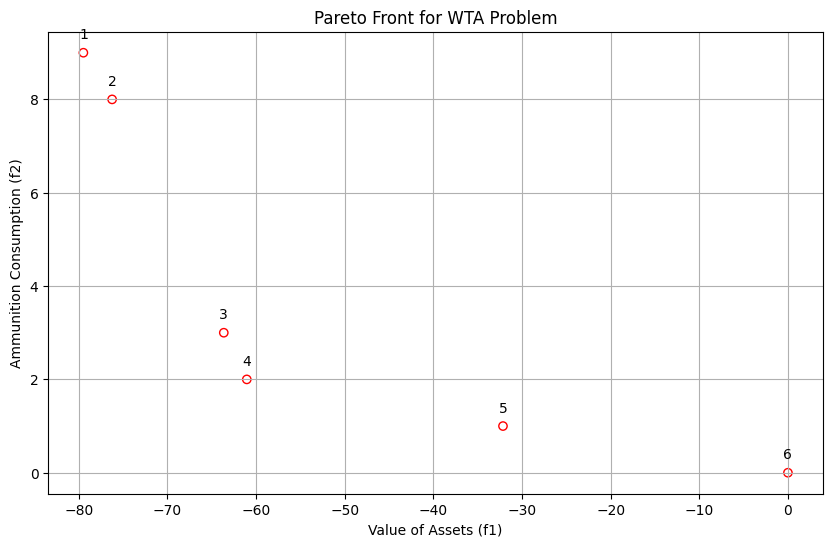

Sorted Solutions and Objective Values:
Solution 1:
Objective Values: [-79.47833164   9.        ]
Decision Variables:
[[[False False False False False]
  [False False False False False]
  [False False False False False]]

 [[False False False False False]
  [False False  True False False]
  [False False False False False]]

 [[False False False  True False]
  [ True False False False False]
  [False False False False  True]]]

Solution 2:
Objective Values: [-76.23674965   8.        ]
Decision Variables:
[[[False False False False False]
  [False False False False False]
  [False False False False False]]

 [[False False False False False]
  [False False False False False]
  [False False False False False]]

 [[False False False  True False]
  [ True False False False False]
  [False False False False  True]]]

Solution 3:
Objective Values: [-63.63929884   3.        ]
Decision Variables:
[[[False False False False False]
  [False False False False False]
  [False False False False False]

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from pymoo.visualization.scatter import Scatter

# Assuming 'res' contains the result from the optimization process and 'problem' is defined
# Sort solutions by their first objective value (f1)
sorted_indices = np.argsort(res.F[:, 0])
sorted_F = res.F[sorted_indices]
sorted_X = res.X[sorted_indices]

# Visualization using Matplotlib directly for more customization
plt.figure(figsize=(10, 6))
plt.scatter(sorted_F[:, 0], sorted_F[:, 1], facecolors='none', edgecolors='red')

# Add annotations for each solution
for i in range(len(sorted_F)):
    plt.annotate(f'{i + 1}', (sorted_F[i, 0], sorted_F[i, 1]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title("Pareto Front for WTA Problem")
plt.xlabel("Value of Assets (f1)")
plt.ylabel("Ammunition Consumption (f2)")
plt.grid(True)
plt.show()

# Access the sorted Pareto front solutions and their objective values
print("Sorted Solutions and Objective Values:")
for i, index in enumerate(sorted_indices):
    decision_vars_matrix = np.reshape(sorted_X[i], (problem.S, problem.W, problem.T))
    print(f"Solution {i + 1}:")
    print(f"Objective Values: {sorted_F[i]}")
    print("Decision Variables:")
    print(decision_vars_matrix)
    print()

# Generate LaTeX table for the sorted solutions
latex_table = r"""
\begin{table}[ht]
\centering
\begin{tabular}{|c|c|c|c|}
\hline
Stage & Threat & WS & Decision Variables \\
\hline
"""

for i, index in enumerate(sorted_indices):
    decision_vars_matrix = np.reshape(sorted_X[i], (problem.S, problem.W, problem.T))
    for s in range(problem.S):
        for t in range(problem.T):
            latex_table += f"{s + 1} & T_{t + 1} & "
            ws_values = decision_vars_matrix[s, :, t]
            ws_str = ", ".join([str(int(x)) for x in ws_values])
            latex_table += f"{ws_str} & {sorted_F[i]} \\\\ \n"
            if t == problem.T - 1:
                latex_table += r"\hline" + "\n"

latex_table += r"""
\end{tabular}
\caption{Weapon System Assignments and Objective Values for Sorted Solutions}
\label{table:sorted_solutions}
\end{table}
"""

print(latex_table)


# Choosing the best solution

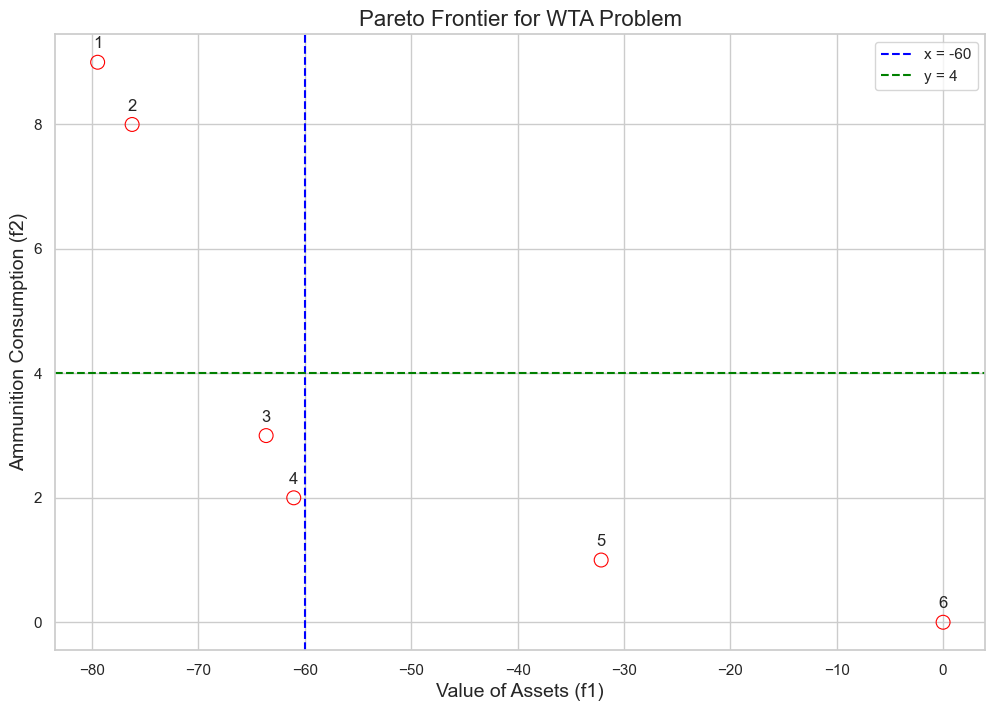

In [102]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pymoo.visualization.scatter import Scatter

# Define the constraints for the axes
x_constraint = -60  # Example value for constraint on x-axis
y_constraint = 4  # Example value for constraint on y-axis

# Assuming 'res' contains the result from the optimization process and 'problem' is defined
# Sort solutions by their first objective value (f1)
sorted_indices = np.argsort(res.F[:, 0])
sorted_F = res.F[sorted_indices]
sorted_X = res.X[sorted_indices]

# Set seaborn style for better visualization
sns.set(style="whitegrid")

# Visualization using seaborn
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x=sorted_F[:, 0], y=sorted_F[:, 1], edgecolor='red', facecolor='none', s=100)

# Add annotations for each solution
for i in range(len(sorted_F)):
    plt.annotate(f'{i + 1}', (sorted_F[i, 0], sorted_F[i, 1]), textcoords="offset points", xytext=(0,10), ha='center')

# Add constraint lines
plt.axvline(x=x_constraint, color='blue', linestyle='--', label=f'x = {x_constraint}')
plt.axhline(y=y_constraint, color='green', linestyle='--', label=f'y = {y_constraint}')

plt.title("Pareto Frontier for WTA Problem", fontsize=16)
plt.xlabel("Value of Assets (f1)", fontsize=14)
plt.ylabel("Ammunition Consumption (f2)", fontsize=14)
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


# Sensitivity analysis of parameters

In [369]:
from pymoo.indicators.hv import Hypervolume
import itertools


# Initial parameter values
initial_params = {
    "n_gen": 5000,
    "pop_size": 300,
}

# Parameters to test
param_ranges = {
    "n_gen": [2000, 7000],
    "pop_size": [300, 500]  # Different values of partitions for reference directions
}

# Function to run the optimization for NSGA-III
def run_nsga2_optimization(seed, n_gen, pop_size):

    algorithm = NSGA2(pop_size=pop_size,
                        sampling=BinaryRandomSampling(),
                        crossover=SinglePointCrossover(prob=0.9),
                        mutation=BitflipMutation(prob=1.0/problem.n_var),
                        n_offsprings=20,
                        eliminate_duplicates=True
                    )

    
    res = minimize(problem,
                   algorithm,
                   termination=('n_gen', n_gen),
                   seed=seed,
                   verbose=False,
                   save_history=True)
    return res


# Function to compute Hypervolume
def compute_hypervolume(F, ref_point):
    try:
        if F is None:
            raise ValueError("The input array F is None.")
        metric = Hypervolume(ref_point=ref_point,
                             norm_ref_point=False,
                             zero_to_one=False)  # Do not normalize to [0,1]
        return metric.do(F)
    except Exception as e:
        print(f"Error in compute_hypervolume: {e}")
        return None

# Run the optimization with initial parameters for NSGA-III
initial_nsga2_result = run_nsga2_optimization(1, **initial_params)

# Calculate Hypervolume for initial result
initial_hv = compute_hypervolume(initial_nsga2_result.F, ref_point=np.array([1.1*0, 1.1*17]))  # Reference point for normalized space

# Store best parameters and hypervolume
best_params = initial_params
best_hv = initial_hv

# List to store hypervolume values for plotting
hypervolume_values = [initial_hv]
n_evals = [0]  # Starting with 0 evaluations

# Generate all combinations of parameters
param_names = list(param_ranges.keys())
combinations = list(itertools.product(*param_ranges.values()))

# Test all combinations for NSGA-III
for combination in combinations:
    params = dict(zip(param_names, combination))
    print(f"Testing combination: {params}")
    new_nsga2_result = run_nsga2_optimization(1, **params)
    new_hv = compute_hypervolume(new_nsga2_result.F, ref_point=np.array([1.1*0, 1.1*9]))
    print(f"Hypervolume for combination {params}: {new_hv}")
    if new_hv == None:
        best_hv = best_hv
        best_params = best_params

    elif new_hv > best_hv:
        best_hv = new_hv
        best_params = params
    # Append hypervolume value for plotting
    hypervolume_values.append(new_hv)
    n_evals.append(sum(new_nsga2_result.history[k].evaluator.n_eval for k in range(len(new_nsga2_result.history))))

print("Best Parameters:")
print(best_params)
print(f"Best Hypervolume: {best_hv}")

# Plotting the hypervolume values to see the progress
plt.figure(figsize=(10, 6))
plt.plot(n_evals, hypervolume_values, color='black', lw=0.7, label="Hypervolume")
plt.scatter(n_evals, hypervolume_values, facecolor="none", edgecolor='black', marker="p")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.grid(True)
plt.show()


Testing combination: {'n_gen': 2000, 'pop_size': 300}
Error in compute_hypervolume: The input array F is None.
Hypervolume for combination {'n_gen': 2000, 'pop_size': 300}: None
Testing combination: {'n_gen': 2000, 'pop_size': 500}


: 

In [21]:
import time

print("crossover probability: ", 0.9)
print("mutation probability: ", 1.0/problem.n_var)

def run_nsga2_optimization(seed, n_gen, pop_size):

    algorithm = NSGA2(pop_size=pop_size,
                        sampling=BinaryRandomSampling(),
                        crossover=SinglePointCrossover(prob=0.9),
                        mutation=BitflipMutation(prob=1.0/problem.n_var),
                        n_offsprings=20,
                        eliminate_duplicates=True
                    )

    
    res = minimize(problem,
                   algorithm,
                   termination=('n_gen', n_gen),
                   seed=seed,
                   verbose=False,
                   save_history=True)
    return res


# Example function to time the execution
def run_algorithm():
    start_time = time.time()
    # Your algorithm execution here
    run_nsga2_optimization(1, 350, 200)
    end_time = time.time()
    return end_time - start_time

# Run multiple times and collect timing data
timing_data1 = []
timing_data2 = []
timing_data3 = []

for _ in range(10):
    execution_time = run_algorithm()
    timing_data3.append(execution_time)





crossover probability:  0.9
mutation probability:  0.0033333333333333335


NameError: name 'NSGA2' is not defined

In [323]:
# Calculate mean and standard deviation of the execution times
mean_time = np.mean(timing_data1)
std_dev_time = np.std(timing_data1)

# mean_time = np.mean(timing_data2)
# std_dev_time = np.std(timing_data2)


# print(timing_data1)

print(f"Mean execution time: {mean_time:.2f} seconds")
print(f"Standard deviation of execution time: {std_dev_time:.2f} seconds")

Mean execution time: 19.56 seconds
Standard deviation of execution time: 11.27 seconds
